# 00.Importing Libraries

In [44]:
!pip install metpy --quiet

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from metpy.calc import heat_index
from metpy.units import units

# 01.Helpers

### 01.01 Constants

In [46]:
features_datasus = ["hospitalizations", "average_stay", "deaths", "mortality_rate"]

### 01.02 Functions

In [47]:
def timelag(df, lag, features):
    for feature in features:
        df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df

# 02.Importing Datasets

In [48]:
# Assigning the raw data path
urlINMET = "https://raw.githubusercontent.com/ThierrryScotto/trabalho_pratico/refs/heads/main/datasets/INMET.csv"
urlSUS = "https://raw.githubusercontent.com/ThierrryScotto/trabalho_pratico/refs/heads/main/datasets/datasus_por_local_internacao_v2.csv"

In [49]:
# Reading the INMET Dataset and deleting the removing the last column Unnamed:19
datasetINMET = pd.read_csv(urlINMET, sep=";",decimal = ',')[:-1]
datasetINMET.head(2)

,DATA,HORA,PRECIPITACAO_TOTAL_HORARIO_MM,PRESSAO_ATMOSFERICA_NIVEL_ESTACAO_HORARIA_MB,PRESSAO_ATMOSFERICA_MAX.NA_HORA_ANT_AUT_MB,PRESSAO_ATMOSFERICA_MIN_NA_HORA_ANT_AUT_MB,RADIACAO_GLOBAL_KJ_m2,TEMPERATURA_DO_AR_BULBO_SECO_HORARIA_C,TEMPERATURA_PONTO_DE_ORVALHO_C,TEMPERATURA_MAXIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_MINIMA_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MAX_NA_HORA_ANT_AUT_C,TEMPERATURA_ORVALHO_MIN_NA_HORA_ANT_AUT_C,UMIDADE_REL_MAX_NA_HORA_ANT_AUT_%,UMIDADE_REL_MIN_NA_HORA_ANT_AUT_%,UMIDADE_RELATIVA_DO_AR_HORARIA_%,VENTO_DIRECAO_HORARIA_GR,VENTO_RAJADA_MAXIMA_M/S,VENTO_VELOCIDADE_HORARIA_M/S,Unnamed: 19
0,2000-09-22,22:00,0.0,1014.1,1014.3,1014.0,13.0,15.7,9.8,17.7,15.6,10.9,9.8,70.0,62.0,68.0,106.0,6.3,2.4,NaN
1,2000-09-22,21:00,0.0,1014.3,1014.3,1014.0,448.0,17.8,10.7,19.8,17.8,10.7,9.4,63.0,51.0,63.0,112.0,4.7,2.2,NaN


# 03.DATASUS pre-processing

In [50]:
# Reading the DATASUS Dataset an renaming columns
datasetDATASUS= pd.read_csv(urlSUS, sep=";",decimal = ',')

datasetDATASUS.rename(columns={
    'Ano/mes processamento': 'date',
    'Internacoes': 'hospitalizations',
    'Media_Permanencia': "average_stay",
    'Obitos': 'deaths',
    'Taxa_Mortalidade': 'mortality_rate'
    }, inplace=True)

datasetDATASUS.head(2)

,date,hospitalizations,average_stay,deaths,mortality_rate
0,..Janeiro/1998,3905,6.3,229,5.86
1,..Fevereiro/1998,3502,5.8,200,5.71


## 03.01 Adjusting the date column

In [51]:
## Ajusting date column format
datasetDATASUS['date'] = datasetDATASUS['date'].str.lstrip('.')

months = {
    'Janeiro': '01', 'Fevereiro': '02', 'Marco': '03', 'Abril': '04',
    'Maio': '05', 'Junho': '06', 'Julho': '07', 'Agosto': '08',
    'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'
}

datasetDATASUS['date'] = datasetDATASUS['date'].replace(months, regex=True).apply(lambda x: x.strip())
datasetDATASUS['date'] = pd.to_datetime(datasetDATASUS['date'], format='%m/%Y')

datasetDATASUS.head(2)

,date,hospitalizations,average_stay,deaths,mortality_rate
0,1998-01-01,3905,6.3,229,5.86
1,1998-02-01,3502,5.8,200,5.71


In [52]:
# Verifying missing dates

start_date = datasetDATASUS["date"].min()
end_date = datasetDATASUS["date"].max()
expected_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

missing_dates = expected_dates.difference(datasetDATASUS["date"])

if missing_dates.empty:
    print("No missing dates")
else:
    print("Missing dates:")
    print(missing_dates)

No missing dates


## 03.02 Raw Dataset Summary

In [53]:
# Generating summary of the dataset including shape, number of non-null values in each column, data types and memory usage
print('-----------------------------------')
print('Sahpe of de dataset:')
print(datasetDATASUS.shape)
print('-----------------------------------')

datasetDATASUS.info()

-----------------------------------
Sahpe of de dataset:
(321, 5)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              321 non-null    datetime64[ns]
 1   hospitalizations  321 non-null    int64         
 2   average_stay      321 non-null    float64       
 3   deaths            321 non-null    int64         
 4   mortality_rate    321 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 12.7 KB


In [54]:
# Generating summary statistics for numerical columns in the dataset
datasetDATASUS.describe()

,date,hospitalizations,average_stay,deaths,mortality_rate
count,321,321.000000,321.000000,321.000000,321.000000
mean,2011-05-02 03:57:45.420560640,3597.043614,6.232087,291.931464,8.229626
min,1998-01-01 00:00:00,2196.000000,5.400000,141.000000,4.810000
25%,2004-09-01 00:00:00,3285.000000,6.000000,259.000000,7.150000
50%,2011-05-01 00:00:00,3523.000000,6.200000,286.000000,8.360000
75%,2018-01-01 00:00:00,3959.000000,6.400000,323.000000,9.220000
max,2024-09-01 00:00:00,4768.000000,7.500000,431.000000,12.390000
std,NaN,448.462190,0.337822,45.881386,1.555928


In [55]:
# Verifying the number of non-null values
datasetDATASUS.isna().sum()

date                0
hospitalizations    0
average_stay        0
deaths              0
mortality_rate      0
dtype: int64

## 03.03 Handling invalid values

In [56]:
# Checking for negative values

for column in datasetDATASUS.columns[1:]:
    print(datasetDATASUS[datasetDATASUS[column] < 0], "\n")

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 

Empty DataFrame
Columns: [date, hospitalizations, average_stay, deaths, mortality_rate]
Index: [] 



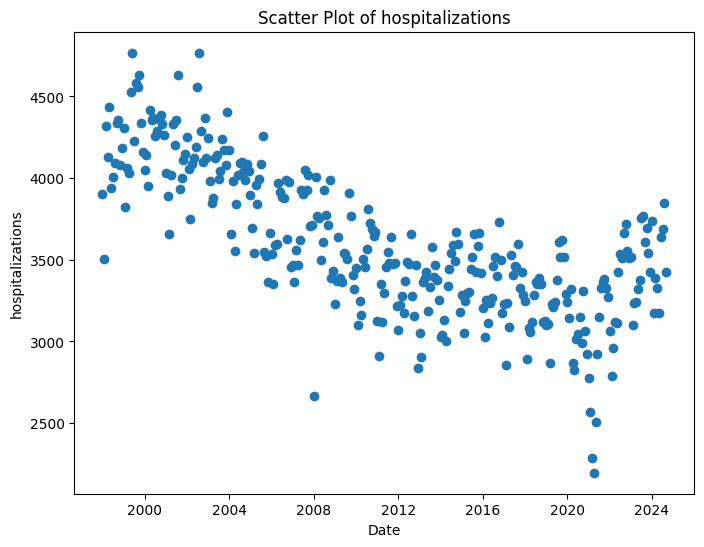

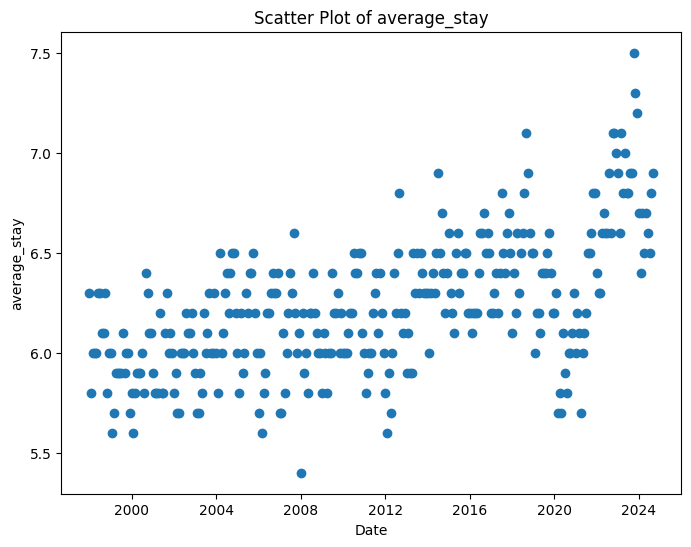

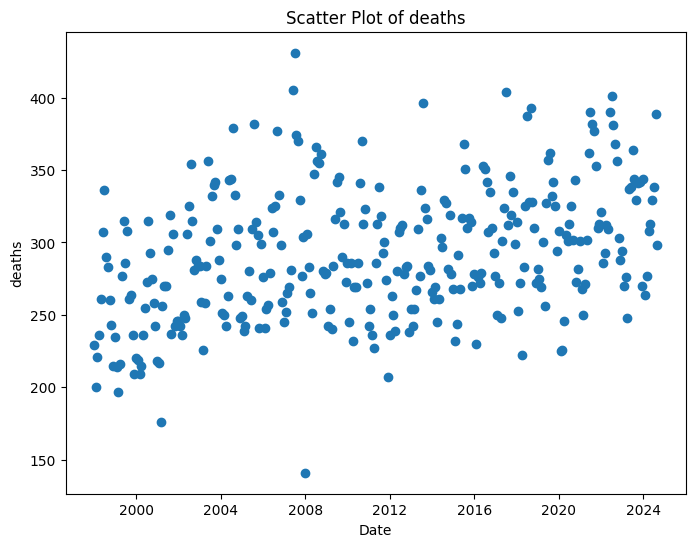

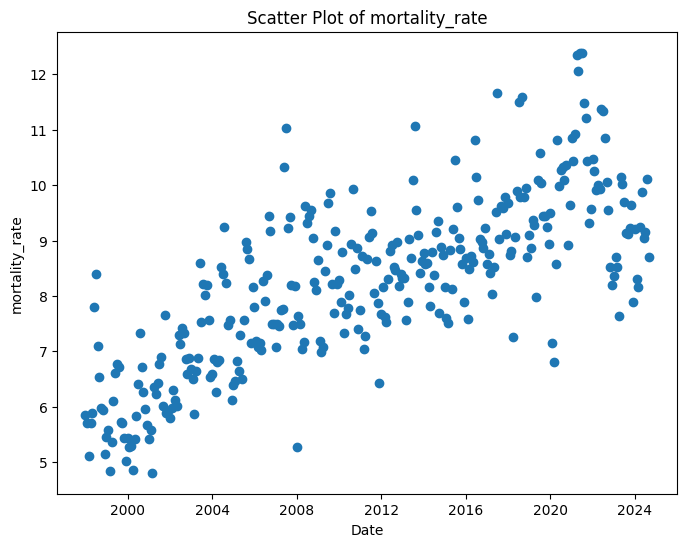

In [57]:
# Checking for unreasonable values

for column in datasetDATASUS.columns[1:]:
    plt.figure(figsize=(8, 6))
    plt.scatter(datasetDATASUS['date'],datasetDATASUS[column])
    plt.title(f'Scatter Plot of {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


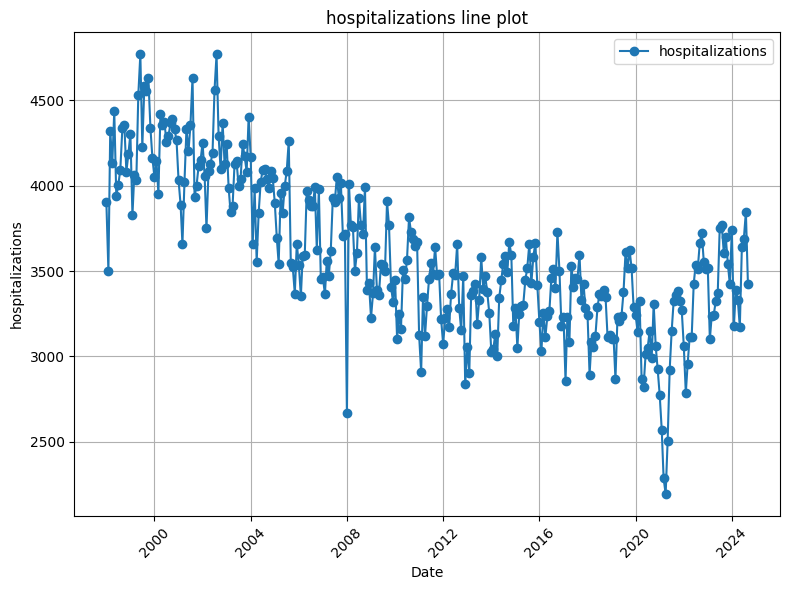

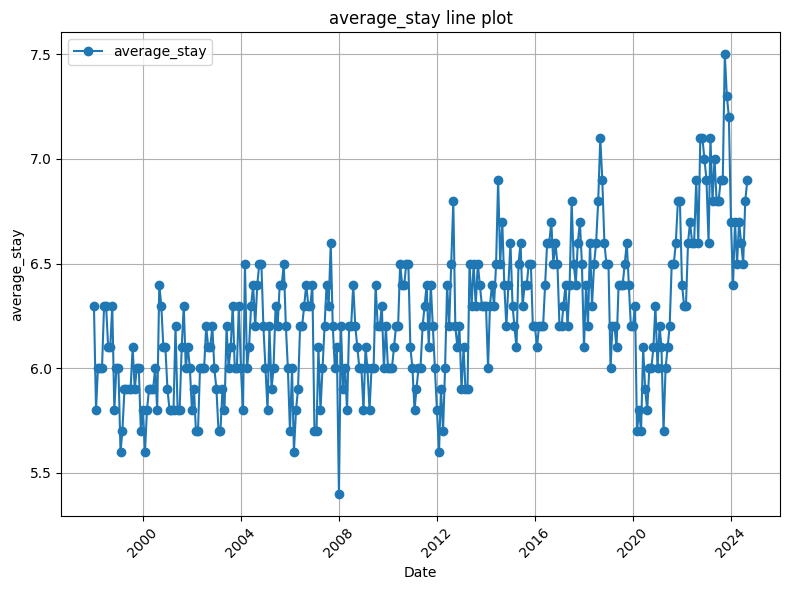

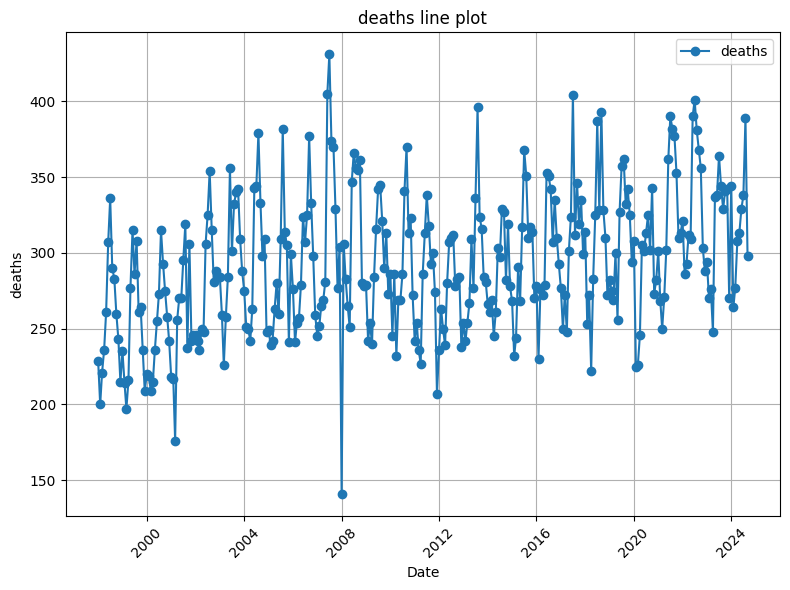

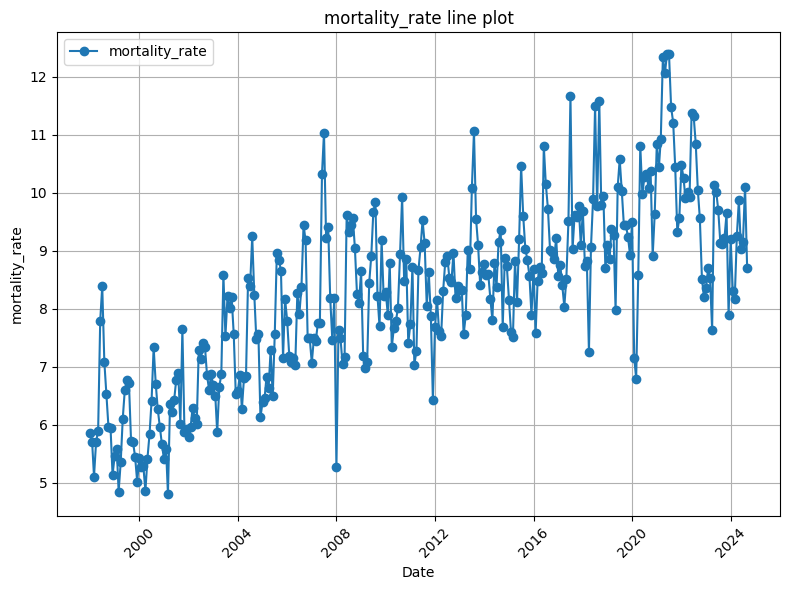

In [24]:
# Checking for unreasonable values

for column in datasetDATASUS.columns[1:]:
    plt.figure(figsize=(8, 6))
    plt.plot(datasetDATASUS['date'],datasetDATASUS[column], marker='o', label=column)
    plt.title(f'{column} line plot')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


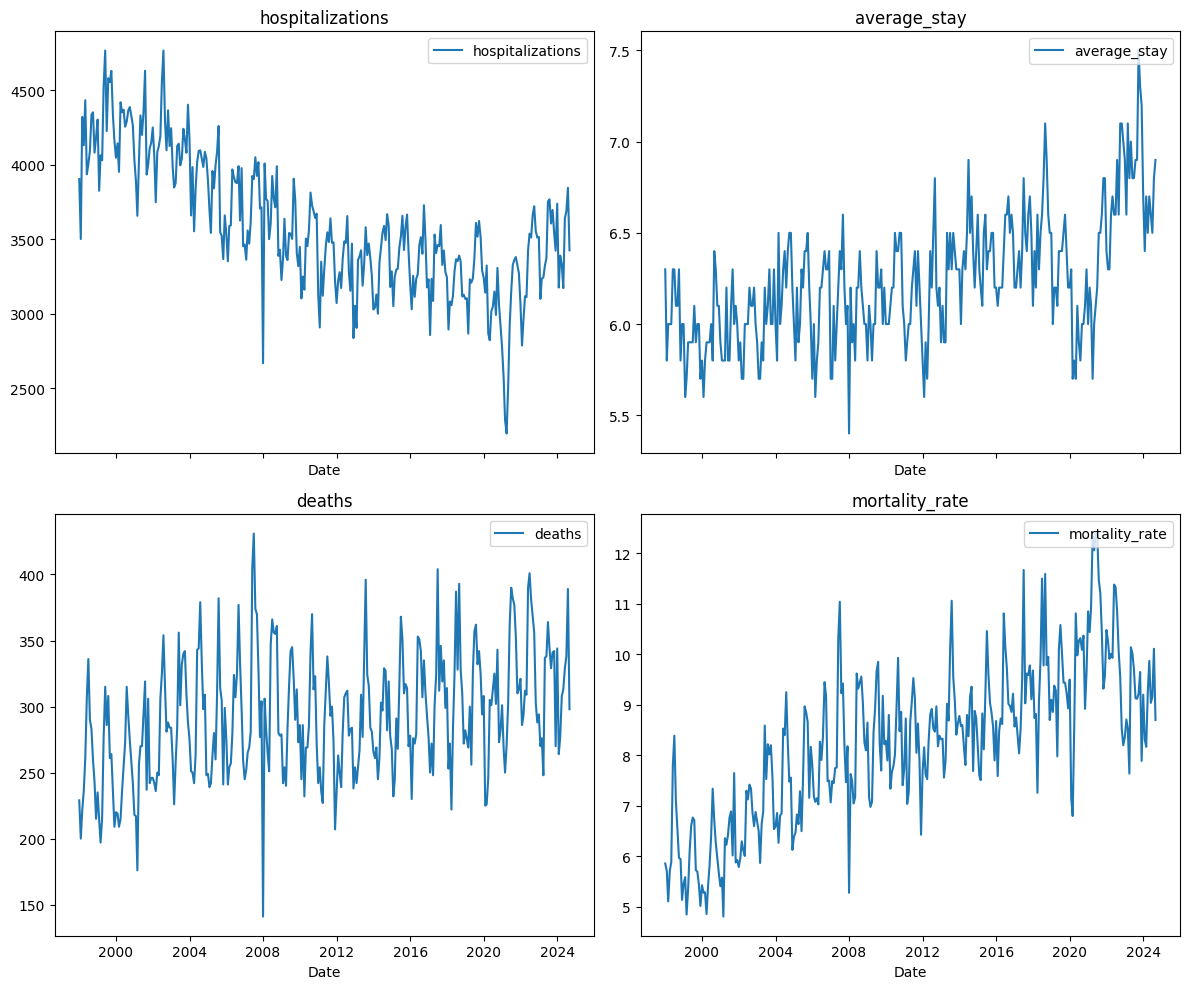

In [58]:
# Creating subplots in a 2x2 matrix
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for index, column in enumerate(datasetDATASUS.columns[1:]):
    axes[index].plot(datasetDATASUS['date'],datasetDATASUS[column], label=column)
    axes[index].set_title(f"{column}")
    axes[index].legend(loc="upper right")
    axes[index].set_xlabel("Date")

plt.xlabel("Date")
plt.tight_layout()
plt.savefig('plotDATASUS.png', dpi=300)
plt.show()

In [59]:
# Outliers in number of deaths
datasetDATASUS[(datasetDATASUS['deaths'] >  400) |  (datasetDATASUS['deaths'] < 150)]

,date,hospitalizations,average_stay,deaths,mortality_rate
113,2007-06-01,3925,6.2,405,10.32
114,2007-07-01,3904,6.4,431,11.04
120,2008-01-01,2668,5.4,141,5.28
234,2017-07-01,3461,6.8,404,11.67
294,2022-07-01,3538,6.6,401,11.33


## 03.04 Feature engineering

In [60]:
# Generating the timelags to include other cardiovascular features in the model

datasetDATASUS_with_lags = datasetDATASUS.copy()
columns = datasetDATASUS.columns[1:]
lags = [3]

for lag in lags:
    for column in columns:
        datasetDATASUS_with_lags[f'{column}_lag_{lag}'] = datasetDATASUS[column].shift(lag)

datasetDATASUS_with_lags = datasetDATASUS_with_lags.dropna()

# transforming deaths and hospitalization columns in integers

for column in datasetDATASUS_with_lags.columns:
    if ('deaths' in column) | ('hospitalization' in column):
        datasetDATASUS_with_lags[column] = datasetDATASUS_with_lags[column].astype(int)
        print(f'{column} column type changed to int')

hospitalizations column type changed to int
deaths column type changed to int
hospitalizations_lag_3 column type changed to int
deaths_lag_3 column type changed to int


In [61]:
#Generating 12 month sliding window for the timelag features. to capture seasonaility

columns = datasetDATASUS_with_lags.columns[1:]

for column in columns:
    if 'lag' in column: 
        new_column = column + '_12m_window' 
        datasetDATASUS_with_lags[new_column] = datasetDATASUS_with_lags[column].rolling(window=12).mean()

In [62]:
# Transforming date column to the same format as INMET
datasetDATASUS_with_lags['date'] = datasetDATASUS_with_lags['date'].dt.strftime('%Y-%m')

In [40]:
datasetDATASUS_with_lags

,date,hospitalizations,hospitalizations_lag_3,average_stay_lag_3,deaths_lag_3,mortality_rate_lag_3,hospitalizations_lag_3_12_m_window,average_stay_lag_3_12_m_window,deaths_lag_3_12_m_window,mortality_rate_lag_3_12_m_window,hospitalizations_lag_3_12m_window,average_stay_lag_3_12m_window,deaths_lag_3_12m_window,mortality_rate_lag_3_12m_window,hospitalizations_lag_3_12_m_window_12m_window,average_stay_lag_3_12_m_window_12m_window,deaths_lag_3_12_m_window_12m_window,mortality_rate_lag_3_12_m_window_12m_window
3,1998-04,4132,3905,6.3,229,5.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-05,4434,3502,5.8,200,5.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1998-06,3937,4322,6.0,221,5.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1998-07,4004,4132,6.0,236,5.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1998-08,4093,4434,6.0,261,5.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2024-05,3172,3176,6.4,264,8.31,3490.333333,6.950000,316.416667,9.045833,3490.333333,6.950000,316.416667,9.045833,3461.194444,6.908333,318.166667,9.176806
317,2024-06,3640,3390,6.7,277,8.17,3503.083333,6.916667,316.500000,9.015833,3503.083333,6.916667,316.500000,9.015833,3468.326389,6.916667,317.125000,9.126528
318,2024-07,3689,3329,6.5,308,9.25,3510.166667,6.891667,321.500000,9.150000,3510.166667,6.891667,321.500000,9.150000,3475.166667,6.921528,316.944444,9.103889
319,2024-08,3846,3172,6.7,313,9.87,3497.666667,6.866667,319.500000,9.127500,3497.666667,6.866667,319.500000,9.127500,3479.506944,6.922222,316.402778,9.077917


## 03.05 Saving the Dataset

In [63]:
#removing present values of average_stay, death and mortality_rate
datasetDATASUS_with_lags = datasetDATASUS_with_lags.drop(['average_stay', 'deaths', 'mortality_rate'], axis=1)

datasetDATASUS_with_lags.to_csv('datasetDATASUS.csv', index=False)

In [64]:
# Generating summary of the dataset including shape, number of non-null values in each column, data types and memory usage
print('-----------------------------------')
print('Shape of de dataset:')
print(datasetDATASUS_with_lags.shape)
print('-----------------------------------')

datasetDATASUS_with_lags.info()

-----------------------------------
Shape of de dataset:
(318, 10)
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 3 to 320
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   date                               318 non-null    object 
 1   hospitalizations                   318 non-null    int64  
 2   hospitalizations_lag_3             318 non-null    int64  
 3   average_stay_lag_3                 318 non-null    float64
 4   deaths_lag_3                       318 non-null    int64  
 5   mortality_rate_lag_3               318 non-null    float64
 6   hospitalizations_lag_3_12m_window  307 non-null    float64
 7   average_stay_lag_3_12m_window      307 non-null    float64
 8   deaths_lag_3_12m_window            307 non-null    float64
 9   mortality_rate_lag_3_12m_window    307 non-null    float64
dtypes: float64(6), int64(3),

## 03.06 Final plot

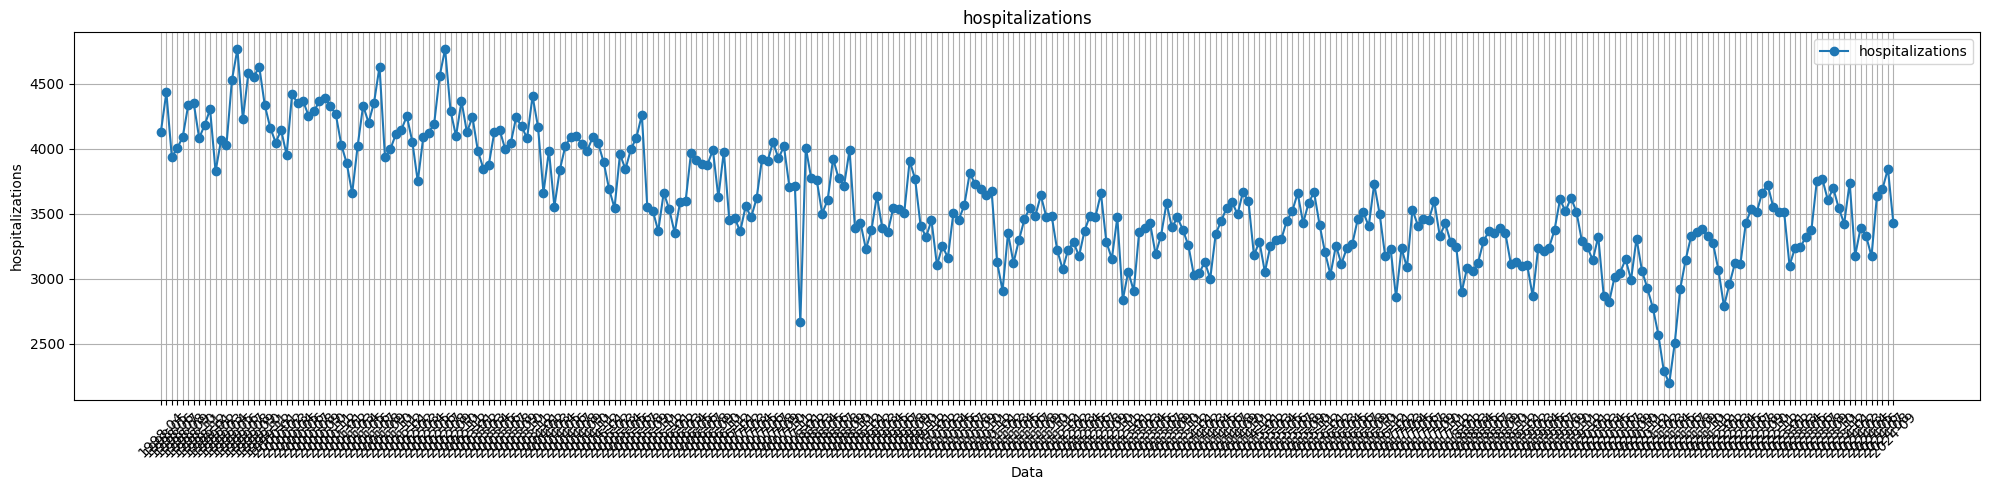

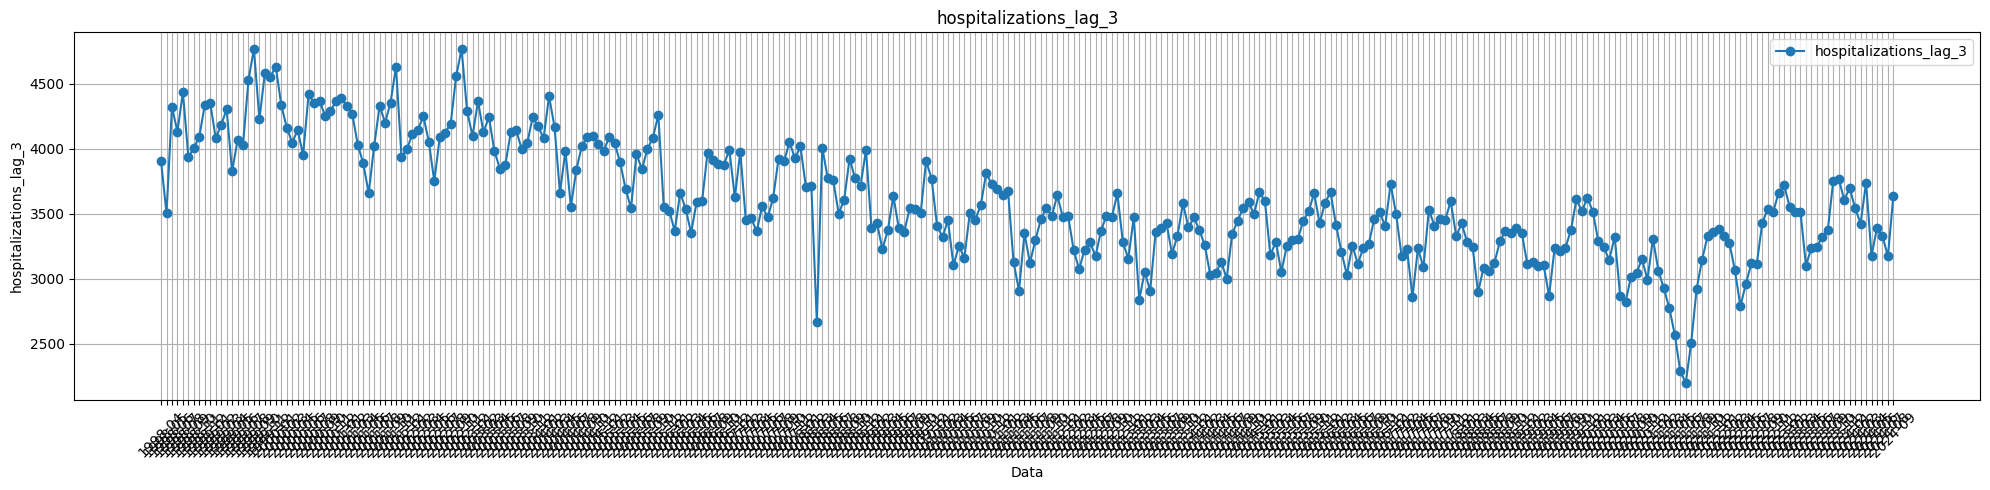

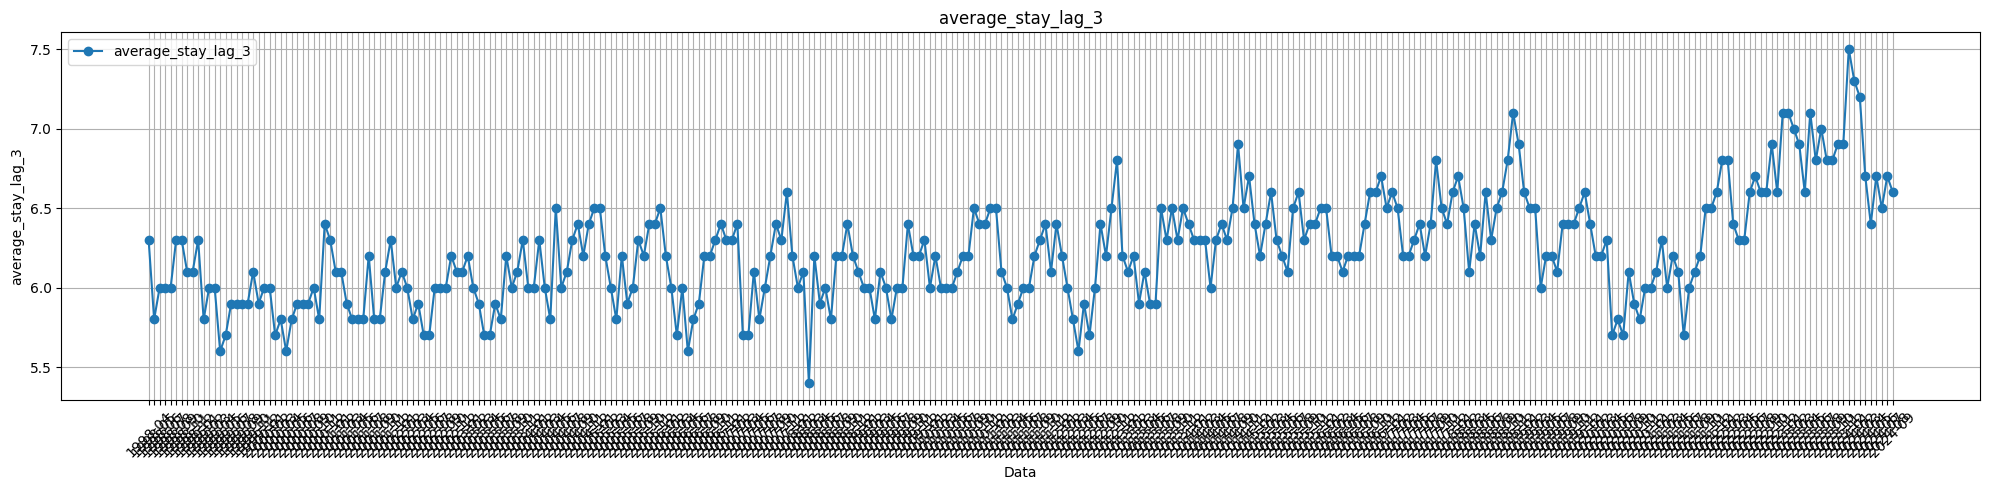

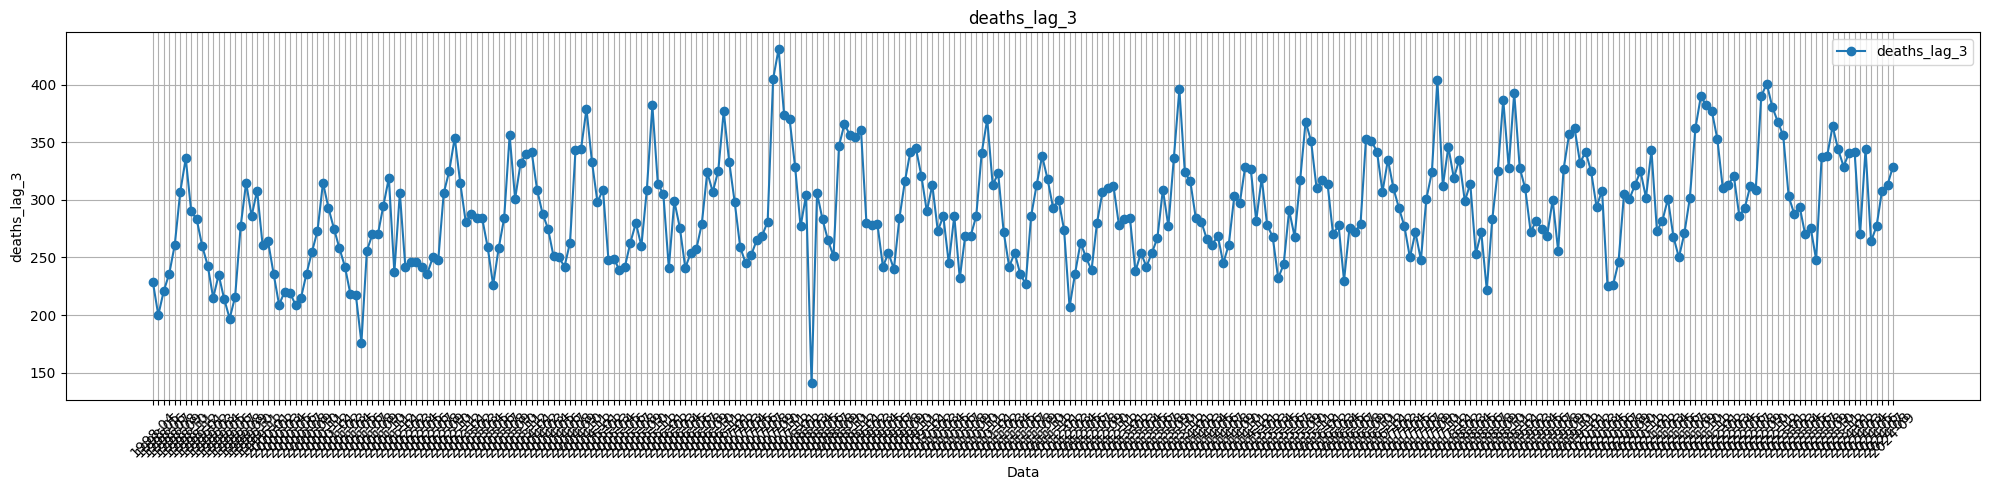

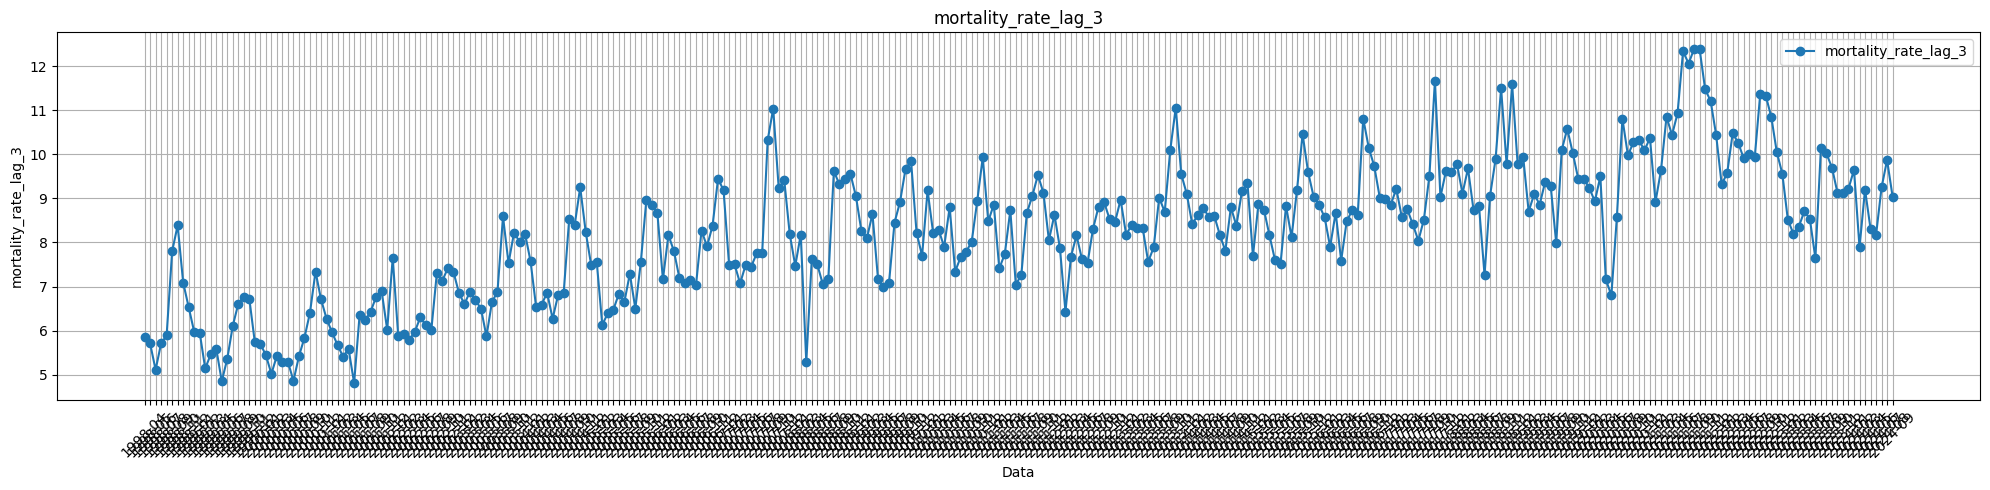

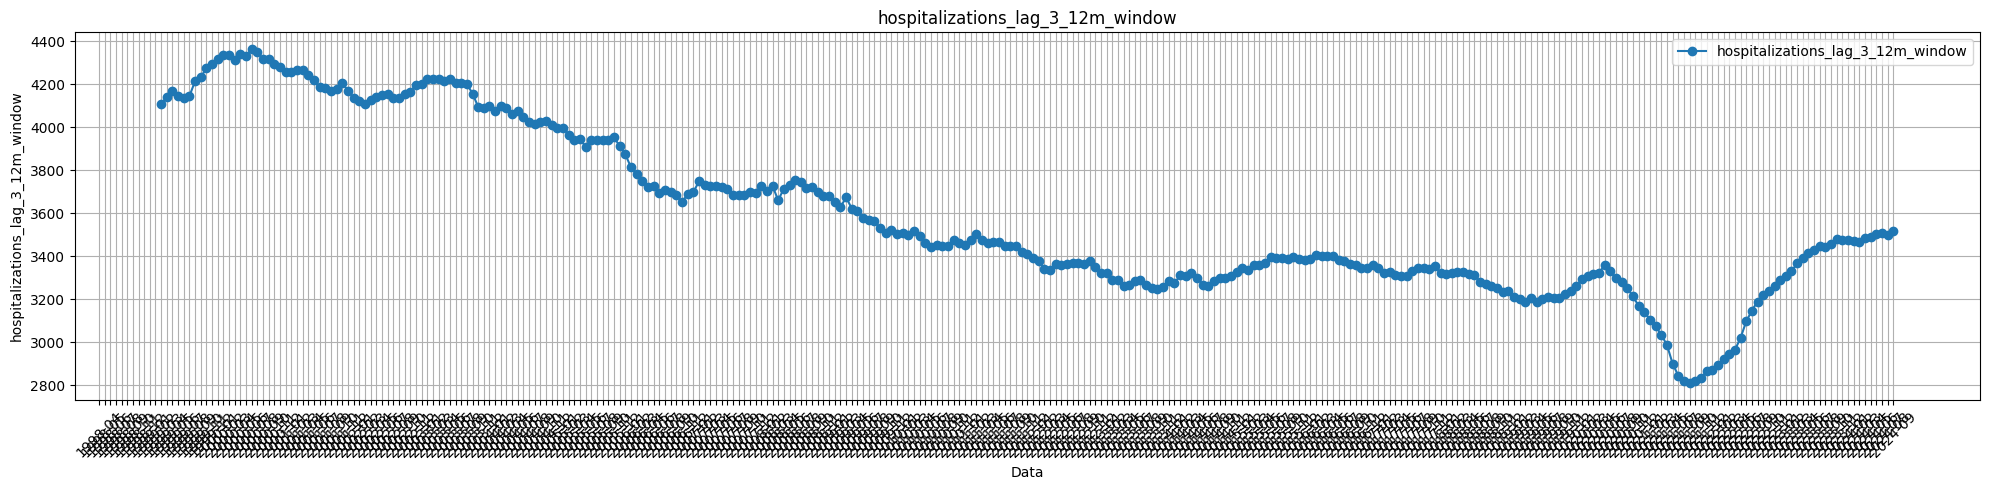

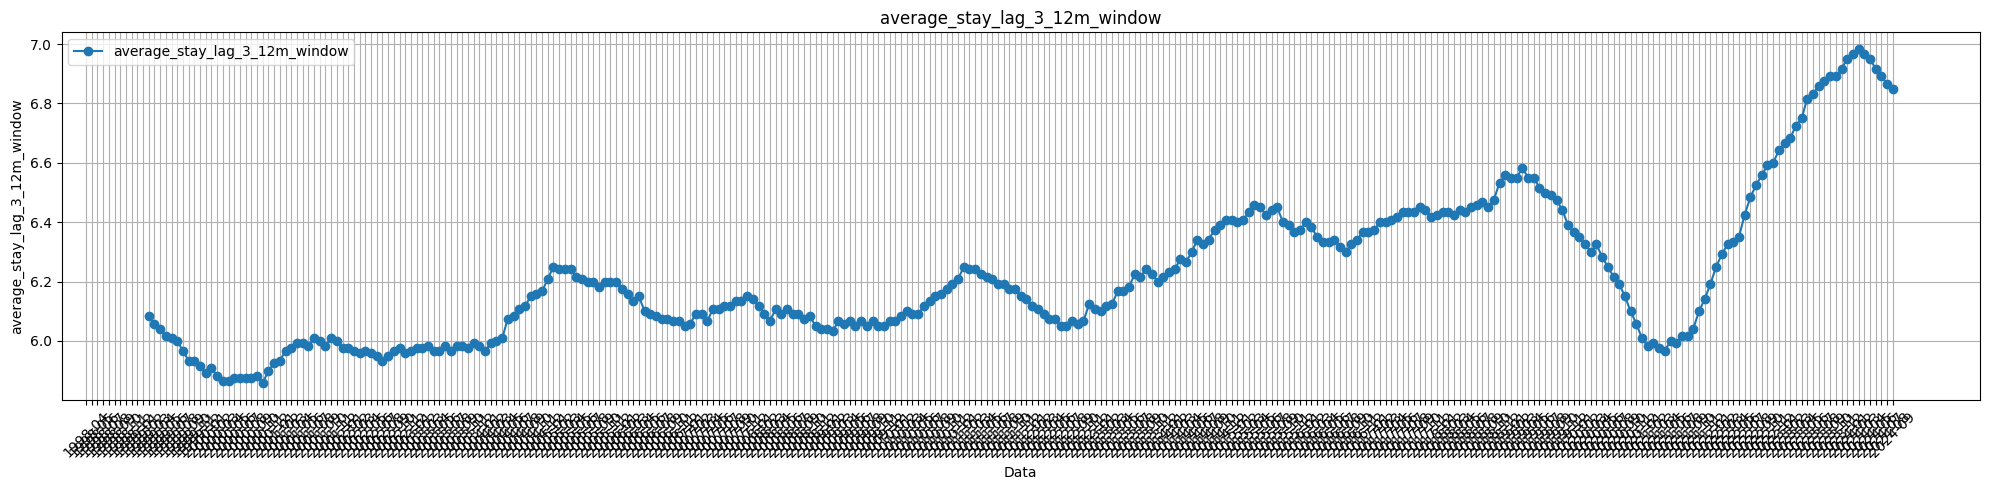

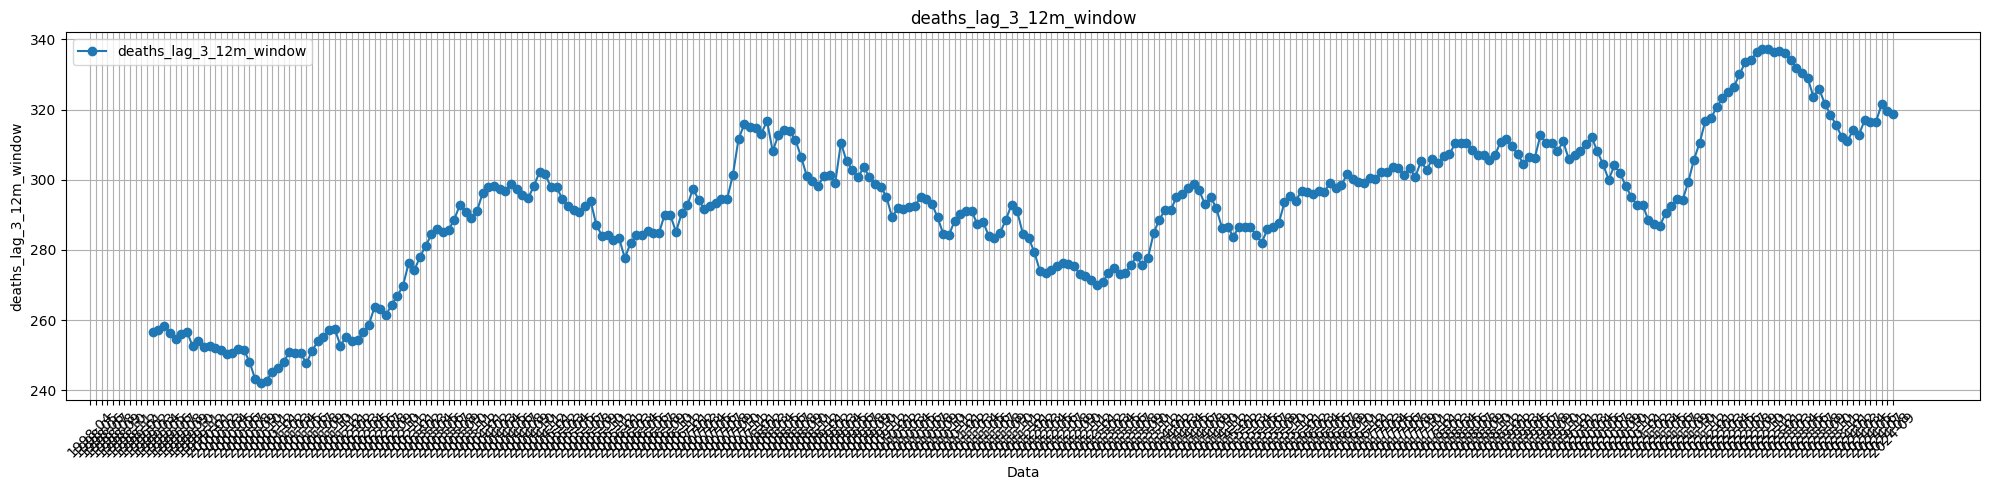

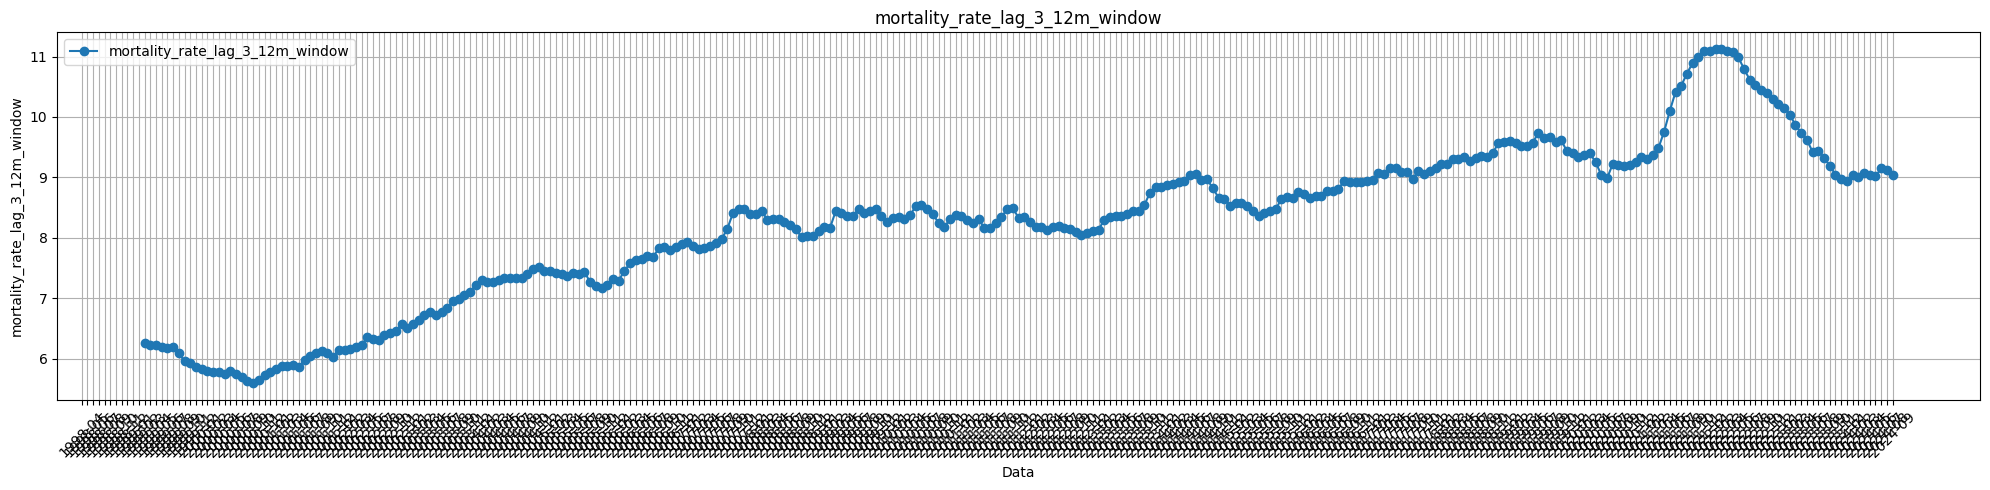

In [65]:
for variable in datasetDATASUS_with_lags.columns[1:]:
    plt.figure(figsize=(20, 5))
    plt.plot(datasetDATASUS_with_lags['date'].values, datasetDATASUS_with_lags[variable], marker='o', label=variable)
    plt.title(f'{variable}')
    plt.xlabel('Data')
    plt.ylabel(variable)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

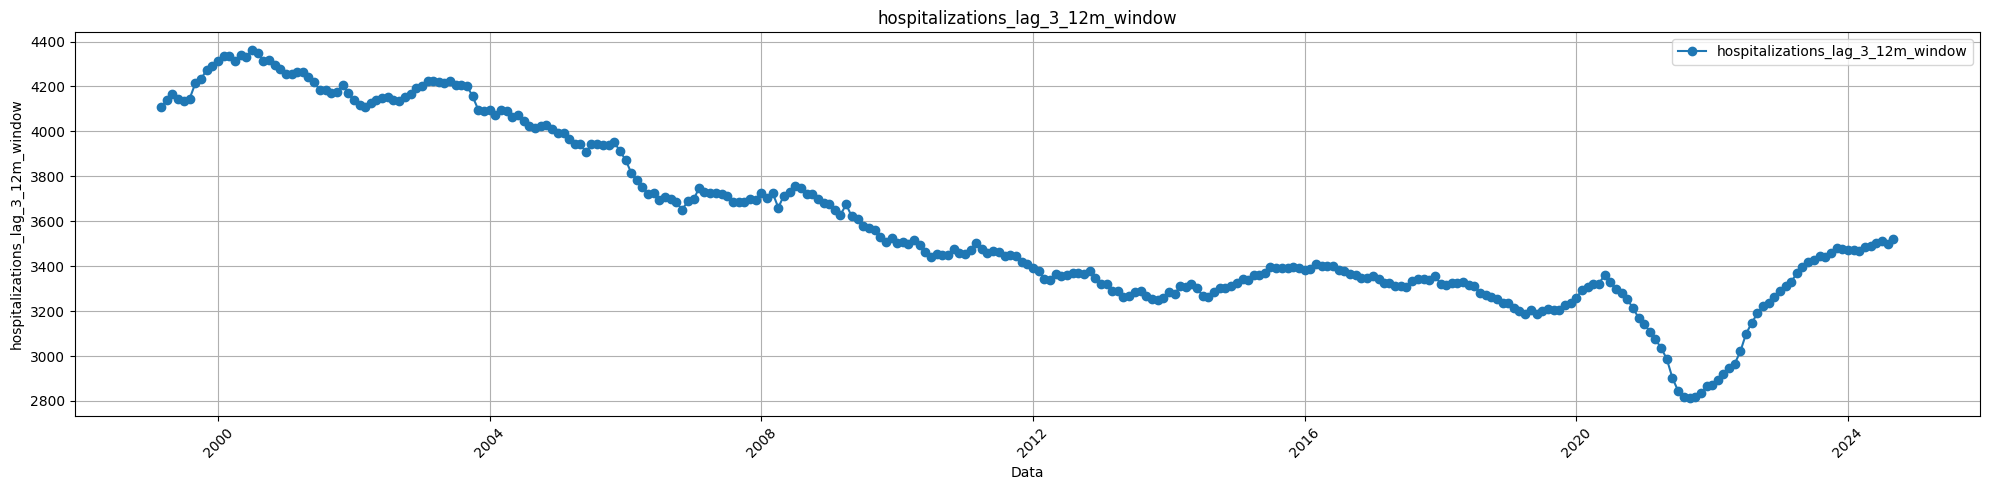

<Figure size 640x480 with 0 Axes>

In [77]:
# Creating subplots in a 2x2 matrix
variable = 'hospitalizations_lag_3_12m_window'
plt.figure(figsize=(20, 5))
plt.plot(pd.to_datetime(datasetDATASUS_with_lags['date'].values), datasetDATASUS_with_lags[variable], marker='o', label=variable)
plt.title(f'{variable}')
plt.xlabel('Data')
plt.ylabel(variable)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.savefig('Hospitalization_12m_window.png', dpi=300)
plt.show()

'1998-04'